In [76]:
import pandas as pd
from matplotlib import pyplot as plt
import plotly.graph_objects as go
import seaborn as sns
import plotly.express as px
from wordcloud import WordCloud
from nltk.corpus import stopwords
import ast
from nltk.tokenize import word_tokenize

In [27]:
#abrimos los 3 csv de los datasets ya limpios
dfjuegos=pd.read_csv('Juegos_steam.csv')
dfitems=pd.read_csv('items_por_usuario.csv')
dfreviews=pd.read_csv('revies_por_usuario.csv')

In [28]:
# corroboramos que en niguna dataframe haya datos nulos
print('Datos nulos en el dataframe de juegos: ',dfjuegos.isnull().sum().sum())
print('Datos nulos en el dataframe de items: ',dfitems.isnull().sum().sum())
print('Datos nulos en el dataframe de reviews: ',dfreviews.isnull().sum().sum())

Datos nulos en el dataframe de juegos:  0
Datos nulos en el dataframe de items:  0
Datos nulos en el dataframe de reviews:  0


In [29]:
#corroboramos que no haya datos duplicados en nigun dataset
print('Datos duplicados en el dataframe de juegos: ',dfjuegos.duplicated().sum())
print('Datos duplicados en el dataframe de items: ',dfitems.duplicated().sum())
print('Datos duplicados en el dataframe de reviews: ',dfreviews.duplicated().sum())

Datos duplicados en el dataframe de juegos:  3
Datos duplicados en el dataframe de items:  0
Datos duplicados en el dataframe de reviews:  0


In [30]:
#se eliminan del dataset los duplicados, aaunque en Etl se verifico que no hubiera duplicados dos veces
dfjuegos.drop_duplicates(inplace=True)
print('Datos duplicados en el dataframe de juegos: ',dfjuegos.duplicated().sum())

Datos duplicados en el dataframe de juegos:  0


# Top 10 años de lanzamiento
Primero obtenemos un top 10 de los años de lanamiento de Videojuegos, para sabaer como estan dstiribuidos los datos de año de lanzamiento, donde observamos que en cada año van aumentando los lanzamientos de videjugos dentro de la plataforma Steam.
Dado que el año 2018 tiene muy pocos lanzamientos, podemos notar que el dataset probablemente sea con datos de principios de año del 2018, ya que se tiene pocos juegos lanzados en ese año. 

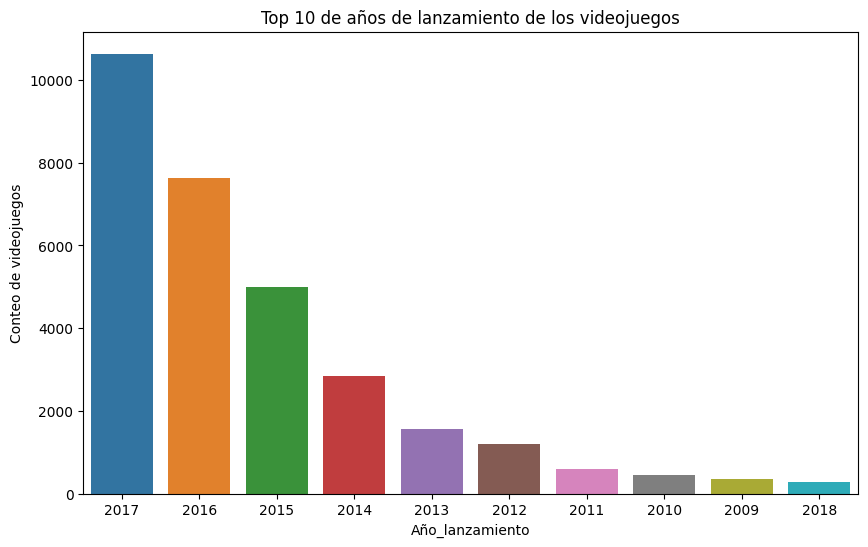

In [31]:
top10años=dfjuegos.Año_lanzamiento.value_counts().nlargest(10).index
conteoaños=dfjuegos[['Año_lanzamiento']][dfjuegos.Año_lanzamiento.isin(top10años)]

plt.figure(figsize=(10,6))
sns.countplot(x='Año_lanzamiento', data=conteoaños, order=top10años)
plt.title('Top 10 de años de lanzamiento de los videojuegos')
plt.ylabel('Conteo de videojuegos')
plt.show()


# Top 10 Géneros mas representativos del dataset de output

En la sigueinte gárfica podemos observar los 10 Géneros que más se repiten dentro del dataset proporcionado, observamos que predomina el mercado el género Indie, seguido de Action y en tercera posición Casual y muy de cerca tenemos a Aventure.
Aquí nos damos una idea general de cuáles géneros predominan en el cátalogo de steam de los datasets proporcionados

In [52]:
generos=dfjuegos.Género.str.replace("[\[\]\']",'',regex=True).str.get_dummies(', ').sum().nlargest(10)
fig = go.Figure(go.Funnel(
    y = generos.index.to_list(),
    x = generos,
    textinfo = "value+percent initial",
    marker = {"color": ["blue", "green", "red", "yellow", "purple",'skyblue','lightgray','gold','seagreen','salmon']}))
fig.update_layout(
    title="Top 10 Géneros mas representativos del dataset de output",
    title_x=0.5 
)
fig.show()

# Distribución de géneros por año

Tenemos un treemap, donde se agurpan los generos, distribuodos por su año de anamiento, para ir visualizando la relevancia de cada Género a través de los años.
Observando la gráfica, vemos que el Género Indie ha predominado el mercado de Steam a partidel año 2014 hasta el 2017, seguido por los géneros action, casual, adventure, strategy, simulation, RPG; pudiendo variar su orden en algunos años, pero siguiendo esta tenddencia de estar a la cabeza, y confirmando el patrón que se muestra en el gráfico anterior.
En este gráfico se peuede ir interactuando con cada año para ahondar un poco mas sobre su información detallada.

In [35]:
top10años=dfjuegos.Año_lanzamiento.value_counts().nlargest(10).index
conteoaños=dfjuegos[['Año_lanzamiento']][dfjuegos.Año_lanzamiento.isin(top10años)]
dfjuegosexpandido=dfjuegos.assign(generos=dfjuegos.Género.str.replace("[\[\]\']",'',regex=True).str.split(', ')).explode('generos')
dfjuegosagrupado=dfjuegosexpandido.groupby(['Año_lanzamiento','generos']).size().reset_index(name='Conteo')

fig = px.treemap(dfjuegosagrupado, path=['Año_lanzamiento', 'generos'], values='Conteo', title='Distribución de géneros por año')

fig.show()

# Recomendaciones True y False
En el siguiente gráfico de pie, podemos visualizar fácilmente que la mayoría de recomendaciones siempre son postivas, y en mucho menor escala las negativas 

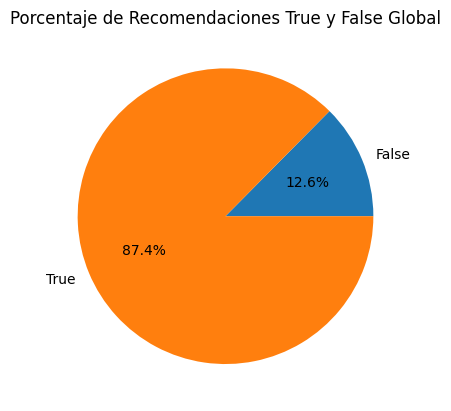

In [36]:
recommend=dfreviews.groupby('Recommend').size()
plt.pie(recommend,labels=recommend.index,autopct='%1.1f%%')
plt.title('Porcentaje de Recomendaciones True y False Global')
plt.show()

# Distribución de analisis de sentimientos de las reviews
Aquí se muestran cual es la proporción de reviews positivas, negativas y neutras, predominando las de valor neutro, después las positivas y luego las negativas, mostrándonos que aunque en la gráfica anterior predominan loas recomendaciones positivas, las reviews neutras están divididas entre las recomendaciones positivas y negativas.

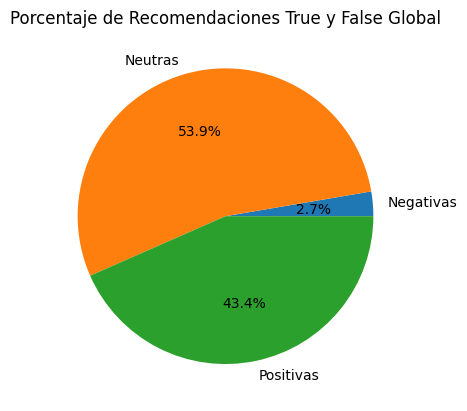

In [37]:
analisissentimientos=dfreviews.groupby('sentiment_analysis').size().reset_index()
analisissentimientos.sentiment_analysis=analisissentimientos.sentiment_analysis.map({2:'Positivas',1:'Neutras',0:'Negativas'})
plt.pie(x=analisissentimientos.loc[:,0],labels=analisissentimientos.sentiment_analysis,autopct='%1.1f%%')
plt.title('Distribución de analisis de sentimientos de las reviews')
plt.show()

In [38]:
dfreviews.Año_review=pd.to_datetime(dfreviews.Año_review)
dfreviewsgeneros=dfreviews.merge(dfjuegos[['Id_juego','Género']])
dfreviewsgeneros['Género']=dfjuegos.Género.str.replace("[\[\]\']",'',regex=True).str.split(', ')
dfreviewsgeneros=dfreviewsgeneros.explode('Género')
dfreviewsgeneros.Año_review=dfreviewsgeneros.Año_review.dt.year
dfreviewsgeneros=dfreviewsgeneros.groupby(['Género','Recommend','Año_review']).size().reset_index(name='Conteo')
generosreviews=dfreviewsgeneros[['Género','Conteo']].groupby('Género').sum().nlargest(5,'Conteo').index.tolist()
dfreviewsgeneros=dfreviewsgeneros[dfreviewsgeneros.Género.isin(generosreviews)]
añosreviews=dfreviewsgeneros.groupby(['Año_review']).sum()
top5añosreviews=añosreviews.Conteo.nlargest(5).index.tolist()
dftop5añosreviews=dfreviewsgeneros[dfreviewsgeneros.Año_review.isin(top5añosreviews)]

# Top 5 de distribución de géneros por años de reviews mas relevantes
Aquí se está plasmando un pco mpas a detalle el top 5 de géneros que más relevancia tienen en los datos, dándonos a notar que las recomendaciones tienen la misma distribución en cada año, siguiendo la misma tendencia en los Géneros plasmados, mostrando el mismo patrón en las recomendaciones negativas aunque en menor mediad debido a la proporción observada anteriormente de recomendaciones positivas contra las negativas.

In [74]:
dftop5añosreviews.loc[:,'Recommend']=dftop5añosreviews.Recommend.astype(str)
fig = px.bar(dftop5añosreviews, x='Año_review', y='Conteo', color='Género', title='Top 5 de distribución de géneros por años de reviews más relevantes',facet_col='Recommend', barmode='group')

fig.show()

# Nube de palabras de las reviews

In [272]:
# abrimos el archivo reviews
with open('australian_user_reviews.json', encoding='utf-8') as archivo_json:
    contenido_json = archivo_json.readlines()
lisreviews=list(map(ast.literal_eval,contenido_json))
dfreviews=pd.DataFrame(lisreviews)
dfreviews=dfreviews.explode('reviews')
reviews=pd.DataFrame(dfreviews['reviews'].to_dict()).loc['review'].to_list()

In [273]:
#quitamos los signos de puntuación más comúnes, sacamos en forma de lista las palabras, y les quitamos las stopwords
reviews=pd.DataFrame(reviews)[0].str.lower().str.replace('[\[\]\{\}\.\"\,\;\:\']','',regex=True)
stop_words = list(stopwords.words('english'))
reviews=reviews.str.split(' ')
palabras=reviews.explode()
palabras=palabras[~palabras.isin(stop_words)]
palabras=palabras[palabras!='']
palabras=palabras[palabras!='game']
#hacemos un Dataframe con las frecuencias de cada palabra
palabras=palabras.value_counts().reset_index()


## Se realizó una nube de palabras resaltando las palabras que más se repiten en las reviews

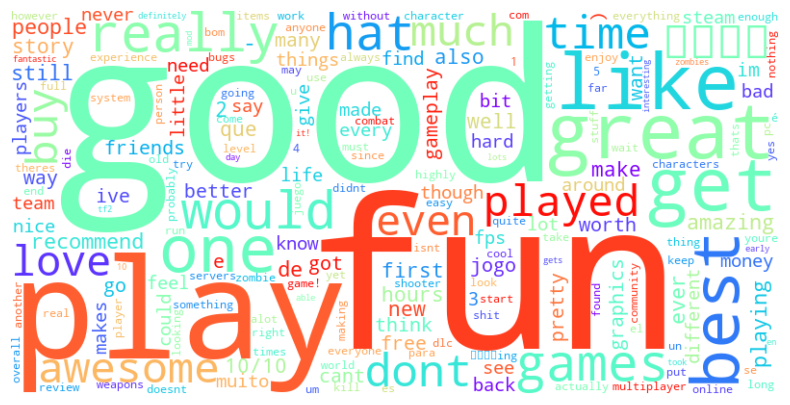

In [274]:
wordcloud = WordCloud(width=800, height=400, background_color='white',colormap='rainbow').generate_from_frequencies(palabras.set_index(0)['count'])

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

# Top 5 géneros más jugados por año de lanzamiento (2006-2017)'

In [44]:
dfitemsgenero=dfitems.merge(dfjuegos[['Id_juego','Género','Año_lanzamiento']],how='left')
dfitemsgenero.dropna(inplace=True)
dfitemsgenero.Género=dfitemsgenero.Género.str.replace('[\[\]\']','',regex=True).str.split(', ')
dfitemsgenero=dfitemsgenero.explode('Género')
dfitemsgeneroagrupado=dfitemsgenero[['Género','Horas_jugadas','Año_lanzamiento']].groupby(['Género','Año_lanzamiento']).sum()
dfitemsgeneroagrupado=dfitemsgeneroagrupado.sort_values(by='Horas_jugadas',ascending=False)
dfitemsgeneroagrupado=dfitemsgeneroagrupado.reset_index()
dfitemsgeneroagrupado


,Id_juego,Nombre_juego,Horas_jugadas,Id_usuario,Género,Año_lanzamiento
0,10,Counter-Strike,0.10,76561197970982479,Action,2000
1,20,Team Fortress Classic,0.00,76561197970982479,Action,1999
2,30,Day of Defeat,0.12,76561197970982479,Action,2003
3,40,Deathmatch Classic,0.00,76561197970982479,Action,2001
4,50,Half-Life: Opposing Force,0.00,76561197970982479,Action,1999


En este gráfico unimos los años de lanzamiento de los juegos, con los géneros, para crear un gráfico donde mostramos los 5 géneros más relevantes,  donde se resalta las horas juagadas por año, y la proporción de horas para cada género, mostrando un panorma diferente, donde se encuentra que el género de accíón es el que más horas jugadas tiene en la mayoría de años registrados, esta tendencia comienza desde el año 2007, sin embargo recordemos que esto solo refleja los años de lanzamiento de los videoejuegos, no el tiempo jugado por año, de cada género.

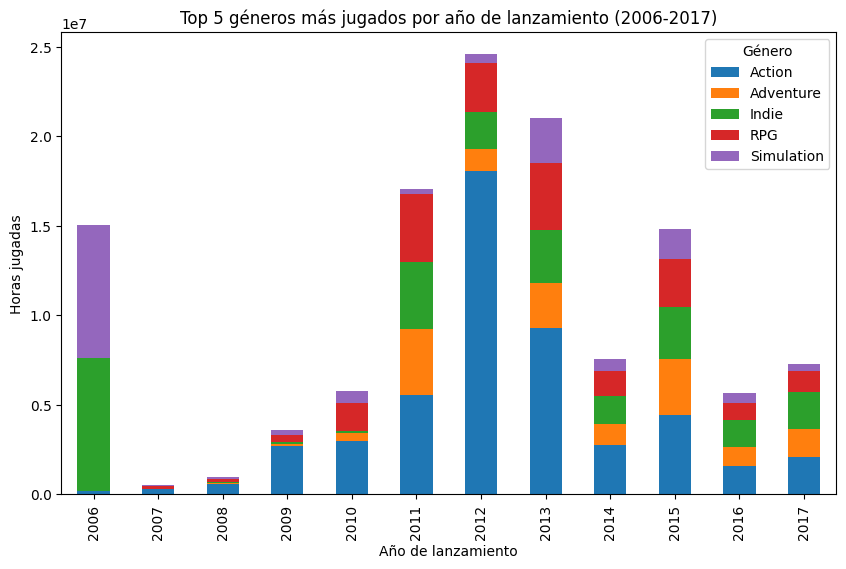

In [53]:
top_5_generos = dfitemsgeneroagrupado.groupby('Género')['Horas_jugadas'].sum().sort_values(ascending=False).head(5).index.tolist()
dfitemsgeneroagrupado=dfitemsgeneroagrupado[dfitemsgeneroagrupado.Género.isin(top_5_generos)]
dfitemsgeneroagrupado = dfitemsgeneroagrupado.pivot(index='Año_lanzamiento', columns='Género', values='Horas_jugadas')
dfitemsgeneroagrupado = dfitemsgeneroagrupado.loc['2006':'2017']
dfitemsgeneroagrupado.plot(kind='bar', stacked=True, figsize=(10,6))
plt.xlabel('Año de lanzamiento')
plt.ylabel('Horas jugadas')
plt.title('Top 5 géneros más jugados por año de lanzamiento (2006-2017)')
plt.show()